# 추론 지연시간 실험
같은 환경 내 같은 데이터셋으로 각 모델 별 inference 수행 후 추론 지연시간 비교

## Set env

In [1]:
!nvidia-smi

Wed Sep 21 09:56:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   41C    P5    20W /  N/A |    200MiB /  6144MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip3 install pillow
!pip3 install numpy==1.21
!pip3 install matplotlib

## Test per model

### Load Dataset

In [3]:
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch

# Image preprocessing modules
train_preprocess = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 8

cifar10_train = dset.CIFAR10('./dataset', train=True, download=True, transform=train_preprocess)
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=4)
train_dataset_size = len(cifar10_train)

cifar10_test = dset.CIFAR10('./dataset', train=False, download=True, transform=test_preprocess)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


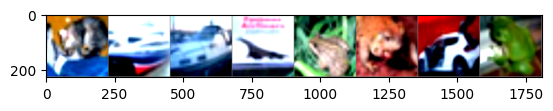

cat   ship  ship  plane frog  frog  car   frog 


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images, 10))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
torch.cuda.is_available()

True

In [6]:
!pip install tqdm

## Load model & Inference
저장한 가중치를 모델에 적용<br>
GPU, CPU 환경에서 각각 인퍼런스 수행

### load model

In [7]:
## models lists
model_res18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, progress=True)
model_res34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=False, progress=True)
model_res50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False, progress=True)
model_res101 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=False, progress=True)
model_res152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=False, progress=True)

Using cache found in /home/keti/.cache/torch/hub/pytorch_vision_v0.10.0
/home/keti/anaconda3/envs/infer_latency/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/keti/anaconda3/envs/infer_latency/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/keti/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/keti/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/keti/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/keti/.cache/torch/hub/pytorch_vision_v0.10.0


##### weight file check

In [8]:
!ls ./models -alF

total 614088
drwxrwxr-x 2 keti keti      4096  9월 20 18:43 ./
drwxrwxr-x 5 keti keti      4096  9월 20 18:53 ../
-rw-rw-r-- 1 keti keti 170708765  9월 20 18:42 res101_weights.pth
-rw-rw-r-- 1 keti keti 233568185  9월 20 18:42 res152_weights.pth
-rw-rw-r-- 1 keti keti  44804557  9월 20 18:39 res18_weights.pth
-rw-rw-r-- 1 keti keti  85298445  9월 20 18:42 res34_weights.pth
-rw-rw-r-- 1 keti keti  94430785  9월 20 18:42 res50_weights.pth


### Inference-time per model

#### ResNet18

In [9]:
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

# gpu/cpu set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')
## parameters
epochs = 3

model_ft = model_res18
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(classes))

## Load weights to model
path = './models/res18_weights.pth'
saved_weights = torch.load(path)
model_ft.load_state_dict(saved_weights)
model_ft = model_ft.to(device)



# Test the model GPU
if torch.cuda.is_available():
    model_ft.to('cuda')

with torch.no_grad():
    start = time.time()
    correct = 0
    total = 0
    for data in tqdm(test_loader, mininterval=0.01):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print("모델명 : model_res18")
    print("Device : GPU")
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    print("소요시간 : ", time.time() - start)
    
# Test the model CPU
device = torch.device('cpu')
model_ft.to('cpu')

with torch.no_grad():
    start = time.time()
    correct = 0
    total = 0
    for data in tqdm(test_loader, mininterval=0.01):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print("모델명 : model_res18")
    print("Device : CPU")
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    print("소요시간 : ", time.time() - start)

100%|███████████████████████████████████████| 1250/1250 [00:25<00:00, 49.48it/s]


모델명 : model_res18
Device : GPU
Accuracy of the model on the test images: 86.72 %
소요시간 :  25.265149116516113


100%|███████████████████████████████████████| 1250/1250 [02:24<00:00,  8.66it/s]

모델명 : model_res18
Device : CPU
Accuracy of the model on the test images: 86.72 %
소요시간 :  144.31395387649536


#### ResNet34

In [10]:
## parameters
epochs = 3

model_ft = model_res34
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(classes))

## Load weights to model
path = './models/res34_weights.pth'
saved_weights = torch.load(path)
model_ft.load_state_dict(saved_weights)
model_ft = model_ft.to(device)


# gpu set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')

# Test the model GPU
if torch.cuda.is_available():
    model_ft.to('cuda')

with torch.no_grad():
    start = time.time()
    correct = 0
    total = 0
    for data in tqdm(test_loader, mininterval=0.01):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print("모델명 : model_res34")
    print("Device : GPU")
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    print("소요시간 : ", time.time() - start)
    
# Test the model CPU
device = torch.device('cpu')
model_ft.to('cpu')

with torch.no_grad():
    start = time.time()
    correct = 0
    total = 0
    for data in tqdm(test_loader, mininterval=0.01):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print("모델명 : model_res34")
    print("Device : CPU")
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    print("소요시간 : ", time.time() - start)

100%|███████████████████████████████████████| 1250/1250 [00:30<00:00, 41.33it/s]


모델명 : model_res34
Device : GPU
Accuracy of the model on the test images: 88.6 %
소요시간 :  30.244954109191895


100%|███████████████████████████████████████| 1250/1250 [03:48<00:00,  5.47it/s]

모델명 : model_res34
Device : CPU
Accuracy of the model on the test images: 88.6 %
소요시간 :  228.3352541923523


#### ResNet50

In [11]:
## parameters
epochs = 3

model_ft = model_res50
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(classes))

## Load weights to model
path = './models/res50_weights.pth'
saved_weights = torch.load(path)
model_ft.load_state_dict(saved_weights)
model_ft = model_ft.to(device)


# gpu set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')

# Test the model GPU
if torch.cuda.is_available():
    model_ft.to('cuda')

with torch.no_grad():
    start = time.time()
    correct = 0
    total = 0
    for data in tqdm(test_loader, mininterval=0.01):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print("모델명 : model_res50")
    print("Device : GPU")
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    print("소요시간 : ", time.time() - start)
    
# Test the model CPU
device = torch.device('cpu')
model_ft.to('cpu')

with torch.no_grad():
    start = time.time()
    correct = 0
    total = 0
    for data in tqdm(test_loader, mininterval=0.01):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print("모델명 : model_res50")
    print("Device : CPU")
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    print("소요시간 : ", time.time() - start)

100%|███████████████████████████████████████| 1250/1250 [00:42<00:00, 29.30it/s]


모델명 : model_res50
Device : GPU
Accuracy of the model on the test images: 89.53 %
소요시간 :  42.65743708610535


100%|███████████████████████████████████████| 1250/1250 [07:47<00:00,  2.67it/s]

모델명 : model_res50
Device : CPU
Accuracy of the model on the test images: 89.53 %
소요시간 :  467.52036595344543


####  ResNet101

In [12]:
## parameters
epochs = 3

model_ft = model_res101
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(classes))

## Load weights to model
path = './models/res101_weights.pth'
saved_weights = torch.load(path)
model_ft.load_state_dict(saved_weights)
model_ft = model_ft.to(device)


# gpu set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')

# Test the model GPU
if torch.cuda.is_available():
    model_ft.to('cuda')

with torch.no_grad():
    start = time.time()
    correct = 0
    total = 0
    for data in tqdm(test_loader, mininterval=0.01):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print("모델명 : model_res101")
    print("Device : GPU")
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    print("소요시간 : ", time.time() - start)
    
# Test the model CPU
device = torch.device('cpu')
model_ft.to('cpu')

with torch.no_grad():
    start = time.time()
    correct = 0
    total = 0
    for data in tqdm(test_loader, mininterval=0.01):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print("모델명 : model_res101")
    print("Device : CPU")
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    print("소요시간 : ", time.time() - start)

100%|███████████████████████████████████████| 1250/1250 [01:04<00:00, 19.51it/s]


모델명 : model_res101
Device : GPU
Accuracy of the model on the test images: 90.55 %
소요시간 :  64.07946801185608


100%|███████████████████████████████████████| 1250/1250 [11:44<00:00,  1.77it/s]

모델명 : model_res101
Device : CPU
Accuracy of the model on the test images: 90.55 %
소요시간 :  704.2561693191528


#### ResNet152

In [13]:
## parameters
epochs = 3

model_ft = model_res152
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(classes))

## Load weights to model
path = './models/res152_weights.pth'
saved_weights = torch.load(path)
model_ft.load_state_dict(saved_weights)
model_ft = model_ft.to(device)

# gpu set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')

# Test the model GPU
if torch.cuda.is_available():
    model_ft.to('cuda')

with torch.no_grad():
    start = time.time()
    correct = 0
    total = 0
    for data in tqdm(test_loader, mininterval=0.01):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print("모델명 : model_res152")
    print("Device : GPU")
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    print("소요시간 : ", time.time() - start)
    
# Test the model CPU
device = torch.device('cpu')
model_ft.to('cpu')

with torch.no_grad():
    start = time.time()
    correct = 0
    total = 0
    for data in tqdm(test_loader, mininterval=0.01):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print("모델명 : model_res152")
    print("Device : CPU")
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
    print("소요시간 : ", time.time() - start)

100%|███████████████████████████████████████| 1250/1250 [01:26<00:00, 14.50it/s]


모델명 : model_res152
Device : GPU
Accuracy of the model on the test images: 91.76 %
소요시간 :  86.22958540916443


100%|███████████████████████████████████████| 1250/1250 [16:50<00:00,  1.24it/s]

모델명 : model_res152
Device : CPU
Accuracy of the model on the test images: 91.76 %
소요시간 :  1010.4093790054321
